In [1]:
import torch
from pathlib import Path
import torch
import torchvision
from torch import nn
from torchvision import transforms
from dataclasses import dataclass
from torch.utils.tensorboard import SummaryWriter  

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
device

'cuda'

In [3]:
@dataclass
class ModelArgs:
    latent_vector_size = 100
    device = 'cpu'
    batch_size = 64
    lr = 1e-4
    num_classes = 10
    img_size = 64
    no_of_lables = 10
    no_of_channels = 1
    nCritic = 5
    beta_1 = 0
    beta_2 = 0.9
    penalty_fac = 10


In [4]:
ModelArgs.device = device

In [5]:
#Transforms for images
transforms = torchvision.transforms.Compose([
    transforms.Resize(size=(ModelArgs.img_size,ModelArgs.img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))

])

In [6]:
#Loading MNIST Dataset
import torchvision
from torch.utils.data import DataLoader
import os

data_path = Path('/data/')

# train_dir = data_path / "train"
# test_dir = data_path / "test"

# Load the training set
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=ModelArgs.batch_size, shuffle=True)

# Load the test set
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=ModelArgs.batch_size, shuffle=False)

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)  #mean = 0, std = 0.02


In [8]:
class Generator(nn.Module):
    def __init__(
        self,
        latent_vector_size = 100,
        no_of_channels = 1,
        kernel_size = (4,4),
        stride: int = 2,
        number_of_feature_maps: int = 64,
        padding: int = 1,
        img_size: int = 1

    ):

        super().__init__()


        self.dense = nn.Linear(in_features=latent_vector_size, out_features=img_size * img_size, device=device)
        self.combined_hidden_layer_dimensions = latent_vector_size + ModelArgs.no_of_lables
        self.embedding = nn.Embedding(num_embeddings=ModelArgs.num_classes, embedding_dim=latent_vector_size, device=device)
        self.img_size = img_size
        self.main = nn.Sequential(


            nn.ConvTranspose2d(ModelArgs.latent_vector_size + ModelArgs.latent_vector_size, number_of_feature_maps * 16 , kernel_size=kernel_size, stride=stride, padding=0, bias=False),
            nn.InstanceNorm2d(number_of_feature_maps * 16),
            nn.ReLU(),

            #shape = (...,1024, 4, 4)
            nn.ConvTranspose2d(number_of_feature_maps * 16, number_of_feature_maps * 8 , kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.InstanceNorm2d(number_of_feature_maps * 8),
            nn.ReLU(),

            #shape = (..., 512, 8, 8)
            nn.ConvTranspose2d(number_of_feature_maps * 8, number_of_feature_maps * 4 , kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.ReLU(),
            nn.InstanceNorm2d(number_of_feature_maps * 4),

             #shape = (..., 256, 16, 16)
            nn.ConvTranspose2d(number_of_feature_maps * 4, number_of_feature_maps * 2 , kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.ReLU(),
            nn.InstanceNorm2d(number_of_feature_maps * 2),

             #shape = (..., 128, 32, 32)
            nn.ConvTranspose2d(number_of_feature_maps * 2, no_of_channels , kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.Tanh()
            #shape = (..., 3, 64, 64)
        )

    def forward(self, x, y):
        labels = self.embedding(y)
        # print(x.shape)
        # print(y.shape)
        labels = labels.unsqueeze(2).unsqueeze(3).view(x.shape[0], ModelArgs.latent_vector_size, 1,1)

        combined = torch.cat([x, labels], dim=1)
        # print(combined.shape)
        out = self.main(combined)
        return out

In [9]:
#Intializing the Generator instance
generator = Generator().to(ModelArgs.device)

#Applying the weights transformation
generator.apply(weights_init)

#Printing the structure
print(generator)

Generator(
  (dense): Linear(in_features=100, out_features=1, bias=True)
  (embedding): Embedding(10, 100)
  (main): Sequential(
    (0): ConvTranspose2d(200, 1024, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): InstanceNorm2d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU()
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU()
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): ReLU()
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): ReLU()
    (11): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (12): ConvTranspose2d(128, 1, kernel_size=

In [51]:
torch.randint(0, 10, (128, 1), dtype=torch.long, device=ModelArgs.device).shape

torch.Size([128, 1])

In [16]:
from torchinfo import summary

random_data = torch.randn(ModelArgs.batch_size, ModelArgs.latent_vector_size, 1, 1, device=ModelArgs.device)
# labels =
labels = torch.randint(0, 10, (64,), dtype=torch.long, device=ModelArgs.device)
random_data = random_data.to(ModelArgs.device)
summary(model=generator,
        
        # input_size=(128, 100, 10, 1, 1),
        input_data=(random_data, labels),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Generator (Generator)                    [64, 100, 1, 1]      [64, 1, 64, 64]      101                  True
├─Embedding (embedding)                  [64]                 [64, 100]            1,000                True
├─Sequential (main)                      [64, 200, 1, 1]      [64, 1, 64, 64]      --                   True
│    └─ConvTranspose2d (0)               [64, 200, 1, 1]      [64, 1024, 4, 4]     3,276,800            True
│    └─InstanceNorm2d (1)                [64, 1024, 4, 4]     [64, 1024, 4, 4]     --                   --
│    └─ReLU (2)                          [64, 1024, 4, 4]     [64, 1024, 4, 4]     --                   --
│    └─ConvTranspose2d (3)               [64, 1024, 4, 4]     [64, 512, 8, 8]      8,388,608            True
│    └─InstanceNorm2d (4)                [64, 512, 8, 8]      [64, 512, 8, 8]      --                   --
│    └─ReLU (5)     

In [13]:
random_data.shape, labels.shape

(torch.Size([128, 100]), torch.Size([128]))

In [141]:

for images, labels in trainloader:

    print(images.shape)
    print(labels.shape)
    break



torch.Size([64, 1, 64, 64])
torch.Size([64])


In [10]:
class Critic(nn.Module):
    def __init__(
        self,
        no_of_channels = 1,
        kernel_size = (4,4),
        stride: int = 2,
        number_of_feature_maps: int = 64,
        padding: int = 1,
        lr_slope=0.2,

    ):

        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=ModelArgs.num_classes, embedding_dim=ModelArgs.img_size * ModelArgs.img_size, device=ModelArgs.device)


        self.main = nn.Sequential(
            nn.Conv2d(no_of_channels + 1, number_of_feature_maps * 2 , kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.InstanceNorm2d(number_of_feature_maps * 2),
            nn.LeakyReLU(negative_slope=lr_slope),

                #shape = (...,1024, 32, 32)
            nn.Conv2d(number_of_feature_maps * 2, number_of_feature_maps * 4 , kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.InstanceNorm2d(number_of_feature_maps * 4),
            nn.LeakyReLU(negative_slope=lr_slope),

                #shape = (..., 512, 16, 16)
            nn.Conv2d(number_of_feature_maps * 4, number_of_feature_maps * 8 , kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.InstanceNorm2d(number_of_feature_maps * 8),
            nn.LeakyReLU(negative_slope=lr_slope),

                #shape = (..., 256, 8, 8)
            nn.Conv2d(number_of_feature_maps * 8, number_of_feature_maps * 16 , kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.InstanceNorm2d(number_of_feature_maps * 16),
            nn.LeakyReLU(negative_slope=lr_slope),
            #  shape = (..., 128, 4, 4)

            nn.Conv2d(number_of_feature_maps * 16, 1 , kernel_size=kernel_size, stride=4, padding=padding, bias=False),
            #shape = (...,1,1)
            nn.Flatten(),
            # nn.Sigmoid(),
         )

    def forward(self, x, y):
        
        y = self.embedding(y)
        B,E = y.shape

        combined = torch.concat([x, y.unsqueeze(2).unsqueeze(3).view(x.shape[0], ModelArgs.no_of_channels, ModelArgs.img_size, ModelArgs.img_size)], dim=1)

        x = self.main(combined)

        return x

In [168]:
# x.view(B, C, IMG_SIZE*IMG_SIZE)

In [169]:
# ModelArgs.device

In [18]:
#Intializing the Discriminator instance
critic = Critic().to(ModelArgs.device)
#Apply the wieght intilization function layer by layer
critic = critic.apply(weights_init)
#Printing the structure
print(critic)

Critic(
  (embedding): Embedding(10, 4096)
  (main): Sequential(
    (0): Conv2d(2, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): InstanceNorm2d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (11): LeakyReLU(negative_slope=0.2)
    (12): Conv2d(1024, 1, kernel_size=(4,

In [20]:
from torchinfo import summary

images = torch.randn(64, 1, 64, 64)
labels = torch.randint(0, 10, (64,), dtype=torch.long)

summary(model=critic,
        # input_size=(100, 1, 64, 64, 10),
        input_data=(images.to(ModelArgs.device), labels.to(ModelArgs.device)),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Critic (Critic)                          [64, 1, 64, 64]      [64, 1]              --                   True
├─Embedding (embedding)                  [64]                 [64, 4096]           40,960               True
├─Sequential (main)                      [64, 2, 64, 64]      [64, 1]              --                   True
│    └─Conv2d (0)                        [64, 2, 64, 64]      [64, 128, 32, 32]    4,096                True
│    └─InstanceNorm2d (1)                [64, 128, 32, 32]    [64, 128, 32, 32]    --                   --
│    └─LeakyReLU (2)                     [64, 128, 32, 32]    [64, 128, 32, 32]    --                   --
│    └─Conv2d (3)                        [64, 128, 32, 32]    [64, 256, 16, 16]    524,288              True
│    └─InstanceNorm2d (4)                [64, 256, 16, 16]    [64, 256, 16, 16]    --                   --
│    └─LeakyReLU (5)

In [22]:


generator = Generator().to(ModelArgs.device).apply(weights_init)
critic = Critic().to(ModelArgs.device).apply(weights_init)


epochs = 10000 #30


optimizerC = torch.optim.Adam(params=critic.parameters(), lr=ModelArgs.lr, betas=(ModelArgs.beta_1, ModelArgs.beta_2)) #For discriminator
optimizerG = torch.optim.Adam(params=generator.parameters(), lr=ModelArgs.lr,  betas=(ModelArgs.beta_1, ModelArgs.beta_2)) #For generator



real_label = 1
fake_label = 0


loss_g = []
loss_d = []
img_list = []

# Fixed noise for generating the images
fixed_noise = torch.randn((ModelArgs.batch_size, ModelArgs.latent_vector_size, 1, 1), dtype=torch.float32, device=ModelArgs.device)

In [12]:
import shutil
save_images = Path('output_images/MNIST/WGAN-GP')


In [23]:
#Training loop
import random
from tqdm import tqdm


generator.train()
critic.train()
iters = 0

writer_fake = SummaryWriter(f"logs/WGAN-GP/fake")
writer_real = SummaryWriter(f"logs/WGAN-GP/real")

for epoch in tqdm(range(epochs)):

    # for X, y in trainloader:
    
    
    # count = 0
    for _ in range(ModelArgs.nCritic):
    
        
        # if(count>=ModelArgs.batch_size):
        #     break
        data_iter = iter(trainloader)

        X, y = next(data_iter)
    
        X = X.to(ModelArgs.device)
        y = y.to(ModelArgs.device)
        
        random_no = random.random()
        # count += 1
        #Train the discriminator (with real data)

        ############################
        # (1) Update D network: maximize: log(1 - D(G(z)))
        ###########################
        # print("noise : ", noise.shape)
        # print("Labels: ", y.shape)
        # print(X.shape)
        # print(y.shape)
        current_batch_size = X.shape[0]  #Getting the current batch size

        critic_real = critic(X,y).view(-1)
        
        noise = torch.randn((current_batch_size, ModelArgs.latent_vector_size, 1, 1), device=ModelArgs.device)
        
        # print('generated noise; ', noise.shape)
        noise_generated_by_generator = generator(noise, y)
        
        critic_fake = critic(noise_generated_by_generator, y)
        
        interpolated = random_no * X + (1-random_no) * noise_generated_by_generator
        
        interpolated_critic_result = critic(interpolated, y).view(-1) 
        
        grad_interpolated_critic_result = torch.autograd.grad(
            create_graph = True,
            retain_graph = True,
            inputs = interpolated,
            outputs = interpolated_critic_result,
            grad_outputs = torch.ones_like(y)
            
        )[0] #Because it will be a tuple consisting of a single tensor
        # print("Autograd result: ",grad_interpolated_critic_result.shape)
        loss_tot = torch.mean(critic_fake) - torch.mean(critic_real) + ModelArgs.penalty_fac * (torch.mean((grad_interpolated_critic_result.view(current_batch_size, -1).norm(2, dim=1) - 1)**2))
        
        # 3. Optimizer zero grad
        optimizerC.zero_grad()

        # 4. Loss backward
        loss_tot.backward()
        # loss_tot.backward(retain_graph=True)
            
        optimizerC.step()
        
    ############################
    # (2) Update G network: minimize log(D(G(z)))
    ###########################

    #1. Forward pass
    noise = torch.randn((current_batch_size, ModelArgs.latent_vector_size, 1, 1), device=ModelArgs.device)
    noise_generated_by_generator = generator(noise, y)
    critic_gen = critic(noise_generated_by_generator, y).view(-1)
    
    loss = -(torch.mean(critic_gen))
    
    # 3. Optimizer zero grad
    optimizerG.zero_grad()

    # 4. Loss backward
    loss.backward(retain_graph=True)
        
    optimizerG.step()
    
    loss_g.append(loss.item())

    # break

    if epoch % 500 == 0:
        print("Iterations: ", iters, "Epoch: ", epoch, "Generator loss: ", loss.item(), "Discriminator loss: ", loss_tot.item())

    #save the output
    with torch.no_grad():
        
        
        
        if epoch % 500 == 0:
            
            print('saving the output')
            # torchvision.utils.save_image(X,'{}/real_images_epoch_{}.png'.format(save_images, epoch),normalize=True)
            fake = generator(fixed_noise, y)
            # torchvision.utils.save_image(fake,'{}/fake_images_epoch_{}.png'.format(save_images, epoch),normalize=True)

            img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
            img_grid_real = torchvision.utils.make_grid(X, normalize=True)
                
            writer_fake.add_image(
                        "Mnist Fake Images", img_grid_fake, global_step=epoch
                    )
            writer_real.add_image(
                        "Mnist Real Images", img_grid_real, global_step=epoch
                    )
                    

            # Check pointing for every epoch
            # torch.save(generator.state_dict(), 'weights/CelebA/generator_steps_%d.pth' % (iters))
            # torch.save(discriminator.state_dict(), 'weights/CelebA/discriminator_steps_%d.pth' % (iters))


        # iters += 1


  0%|          | 1/10000 [00:01<3:42:34,  1.34s/it]

Iterations:  0 Epoch:  0 Generator loss:  11.519918441772461 Discriminator loss:  -16.449831008911133
saving the output


  5%|▌         | 501/10000 [07:27<2:21:21,  1.12it/s]

Iterations:  0 Epoch:  500 Generator loss:  29.872150421142578 Discriminator loss:  -12.99435806274414
saving the output


 10%|█         | 1001/10000 [14:55<2:24:29,  1.04it/s]

Iterations:  0 Epoch:  1000 Generator loss:  26.392879486083984 Discriminator loss:  -8.301973342895508
saving the output


 15%|█▌        | 1501/10000 [22:21<2:01:47,  1.16it/s]

Iterations:  0 Epoch:  1500 Generator loss:  25.922199249267578 Discriminator loss:  -5.191593170166016
saving the output


 20%|██        | 2001/10000 [29:49<2:09:00,  1.03it/s]

Iterations:  0 Epoch:  2000 Generator loss:  28.132633209228516 Discriminator loss:  -6.464010238647461
saving the output


 25%|██▌       | 2501/10000 [37:16<1:55:49,  1.08it/s]

Iterations:  0 Epoch:  2500 Generator loss:  30.21761131286621 Discriminator loss:  -5.609255313873291
saving the output


 30%|███       | 3001/10000 [44:44<1:53:01,  1.03it/s]

Iterations:  0 Epoch:  3000 Generator loss:  29.239627838134766 Discriminator loss:  -5.099191665649414
saving the output


 35%|███▌      | 3501/10000 [52:11<1:43:01,  1.05it/s]

Iterations:  0 Epoch:  3500 Generator loss:  30.635303497314453 Discriminator loss:  -5.528763294219971
saving the output


 40%|████      | 4001/10000 [59:40<1:36:03,  1.04it/s]

Iterations:  0 Epoch:  4000 Generator loss:  27.488082885742188 Discriminator loss:  -5.733362197875977
saving the output


 45%|████▌     | 4501/10000 [1:07:08<1:28:46,  1.03it/s]

Iterations:  0 Epoch:  4500 Generator loss:  31.62683868408203 Discriminator loss:  -3.0006814002990723
saving the output


 50%|█████     | 5001/10000 [1:14:36<1:11:28,  1.17it/s]

Iterations:  0 Epoch:  5000 Generator loss:  30.13888168334961 Discriminator loss:  -3.87677001953125
saving the output


 55%|█████▌    | 5501/10000 [1:22:04<1:12:27,  1.03it/s]

Iterations:  0 Epoch:  5500 Generator loss:  27.979583740234375 Discriminator loss:  -2.9862051010131836
saving the output


 60%|██████    | 6000/10000 [1:29:55<54:33,  1.22it/s]  

Iterations:  0 Epoch:  6000 Generator loss:  29.947967529296875 Discriminator loss:  -2.7335898876190186
saving the output


 65%|██████▍   | 6499/10000 [1:38:34<54:58,  1.06it/s]  

Iterations:  0 Epoch:  6500 Generator loss:  29.766986846923828 Discriminator loss:  -3.5634653568267822
saving the output


 70%|███████   | 7001/10000 [1:46:25<48:42,  1.03it/s]  

Iterations:  0 Epoch:  7000 Generator loss:  29.27762222290039 Discriminator loss:  -3.1902260780334473
saving the output


 75%|███████▌  | 7500/10000 [1:53:53<39:32,  1.05it/s]

Iterations:  0 Epoch:  7500 Generator loss:  29.01172637939453 Discriminator loss:  -4.491480827331543
saving the output


 80%|████████  | 8001/10000 [2:01:21<32:06,  1.04it/s]

Iterations:  0 Epoch:  8000 Generator loss:  29.1839542388916 Discriminator loss:  -2.944528818130493
saving the output


 85%|████████▌ | 8501/10000 [2:08:54<24:19,  1.03it/s]

Iterations:  0 Epoch:  8500 Generator loss:  27.04527473449707 Discriminator loss:  -0.4785466194152832
saving the output


 90%|█████████ | 9001/10000 [2:16:24<14:14,  1.17it/s]

Iterations:  0 Epoch:  9000 Generator loss:  29.589115142822266 Discriminator loss:  -1.7277418375015259
saving the output


 95%|█████████▌| 9501/10000 [2:23:53<07:59,  1.04it/s]

Iterations:  0 Epoch:  9500 Generator loss:  26.414043426513672 Discriminator loss:  -1.4622870683670044
saving the output


100%|██████████| 10000/10000 [2:31:18<00:00,  1.10it/s]


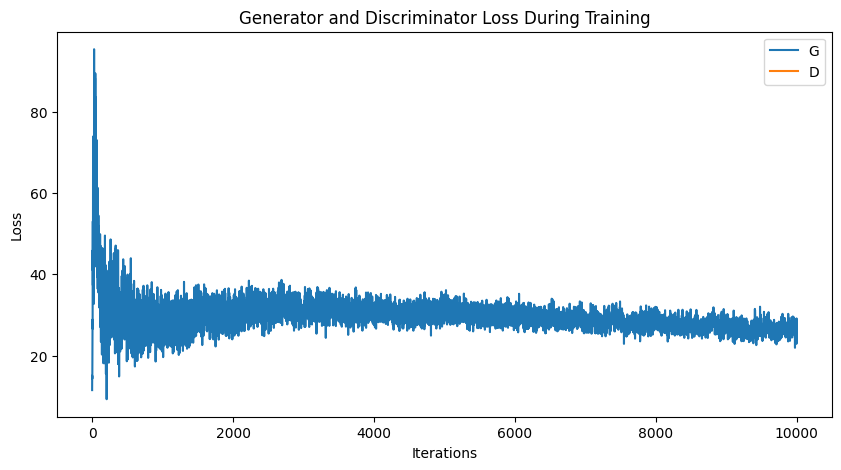

In [24]:
#For MNIST
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(loss_g,label="G")
plt.plot(loss_d,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

